# Equity Options Portfolio Optimization:
**Authors:** William Lester, Luke Rutherford, Dylan Kynoch, Henry Daniel \
**Start Date:** 4/17/2024 \
**Last Updated:** 4/19/2024

In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import data_functions as dat_func, visualizations as vis
import yfinance as yf
from datetime import datetime
import QuantLib as ql
from scipy.optimize import minimize
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

In [2]:
start_date,end_date="2023-04-19",'2024-04-19'
start_date,end_date=pd.to_datetime(start_date),pd.to_datetime(end_date)
trade_dates=dat_func.get_trading_days(start_date,end_date)

tickers = ['XOM', 'WMT', 'GPC', 'OXY', 'PM', 'FI', 'ATKR', 'VICI', 'ADBE', 'AMAT', 'STLD']
ex_stock='XOM'

[*********************100%%**********************]  11 of 11 completed


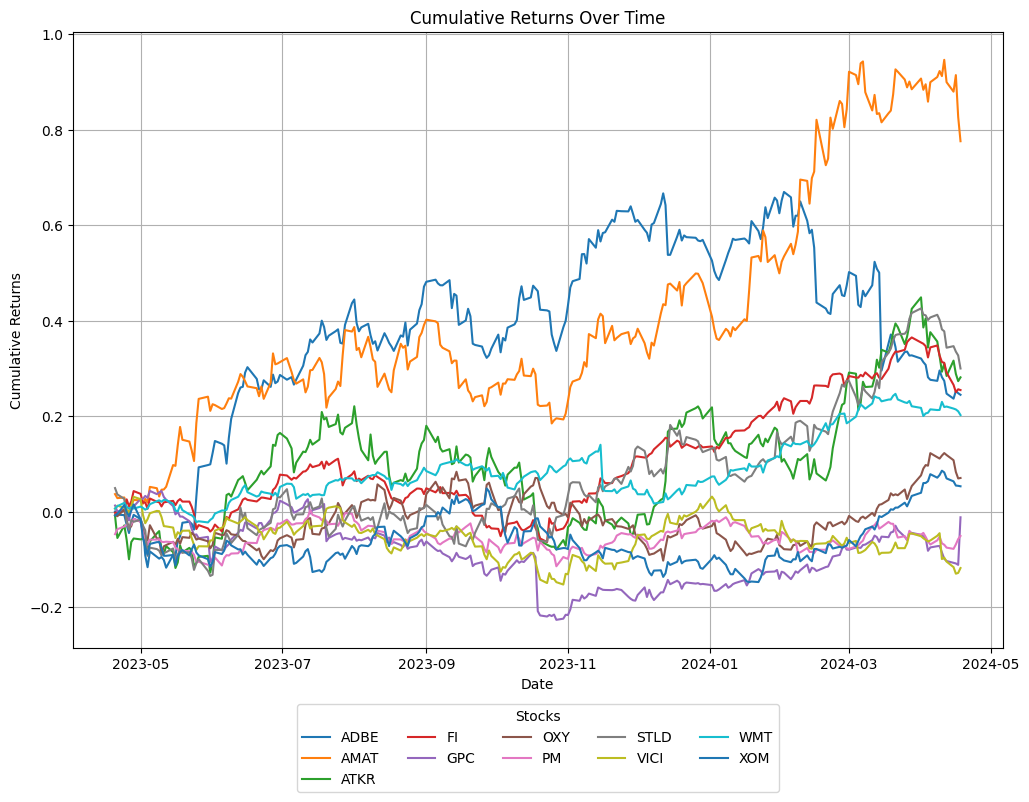

In [3]:
stock_df=dat_func.get_price_df(tickers,start_date,end_date)
returns_df=dat_func.get_log_returns(stock_df)
vis.plot_cumulative_returns(returns_df)

In [4]:
fred,poly=dat_func.connect_apis()
risk_free_rate=fred.get_series('GS10').iloc[-1]/100

In [5]:
init_weights,init_ret,init_std=dat_func.get_init_port(returns_df,risk_free_rate,leverage_limit=1)
init_weights=init_weights.round(3)
print('Initial Port Returns:',init_ret)
print('Initial Port Volatility:',init_std)
print('Initial Port Sharpe:',(init_ret-risk_free_rate)/init_std)
print('Optimal Weights:',dict(zip(returns_df.columns,init_weights)))

Initial Port Returns: 0.23406563145699563
Initial Port Volatility: 0.08586473181321178
Initial Port Sharpe: 2.2356749669304667
Optimal Weights: {'ADBE': -0.0, 'AMAT': 0.162, 'ATKR': 0.0, 'FI': 0.279, 'GPC': -0.037, 'OXY': 0.0, 'PM': -0.053, 'STLD': 0.021, 'VICI': -0.225, 'WMT': 0.213, 'XOM': 0.01}


## Initial Portfolio Simulation:
### Geometric Brownian Motion: 

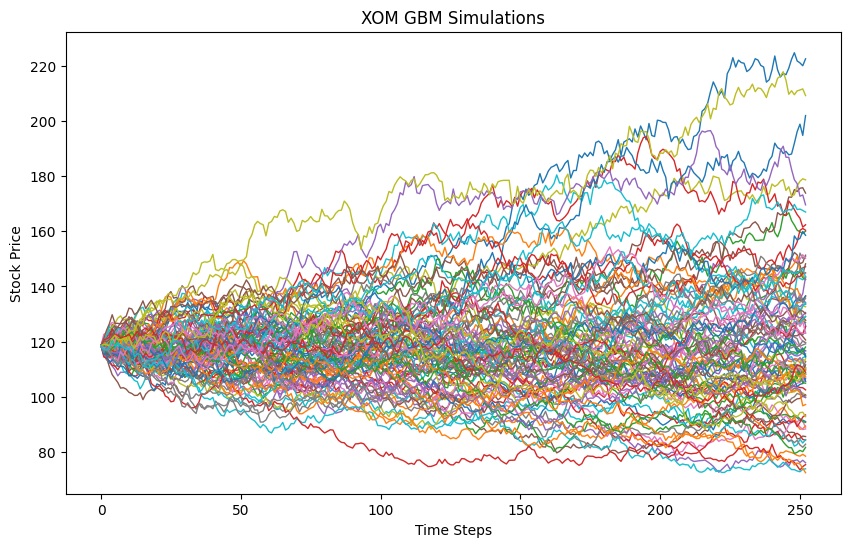

In [6]:
gpc_gbm=dat_func.simulate_gbm(stock_df[ex_stock][-1],returns_df.mean()[ex_stock]*252,returns_df.std()[ex_stock]*np.sqrt(252),1,N=100)
vis.plot_paths(gpc_gbm,f'{ex_stock} GBM',False)

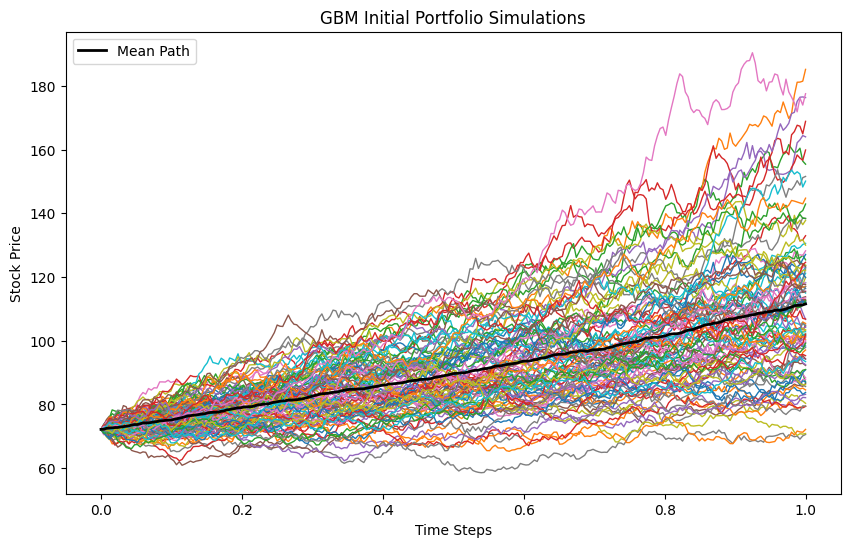

In [7]:
gbm_init_port=dat_func.simulate_gbm_portfolio(returns_df,stock_df,init_weights)
vis.plot_paths(gbm_init_port.iloc[:100],'GBM Initial Portfolio',True)

In [8]:
gbm_ret=(gbm_init_port.mean(axis=0).iloc[-1]-gbm_init_port.mean(axis=0).iloc[0])/gbm_init_port.mean(axis=0).iloc[0]
print(f'GBM Initial Portfolio Return: {round(gbm_ret*100,2)}%')

GBM Initial Portfolio Return: 55.02%


### Merton Jump Diffusion: 

In [9]:
# Estimate the number of jumps, mean jump, and vol of jumps
gpc_lambda_,gpc_m,gpc_v=dat_func.estimate_merton_params(returns_df[ex_stock])

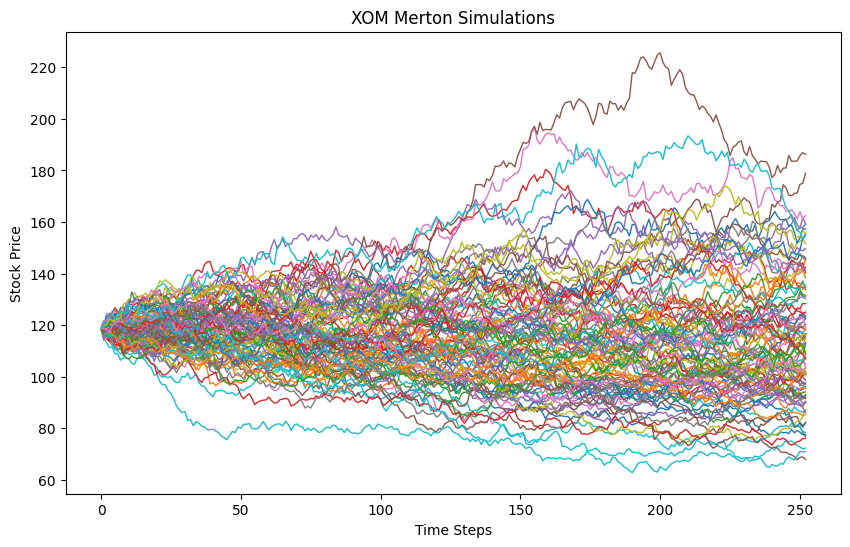

In [10]:
gpc_merton=dat_func.simulate_merton(stock_df[ex_stock][-1],returns_df.mean()[ex_stock]*252,returns_df.std()[ex_stock]*np.sqrt(252),1,gpc_lambda_,gpc_m,gpc_v,1/252,100)
vis.plot_paths(gpc_merton,f'{ex_stock} Merton')

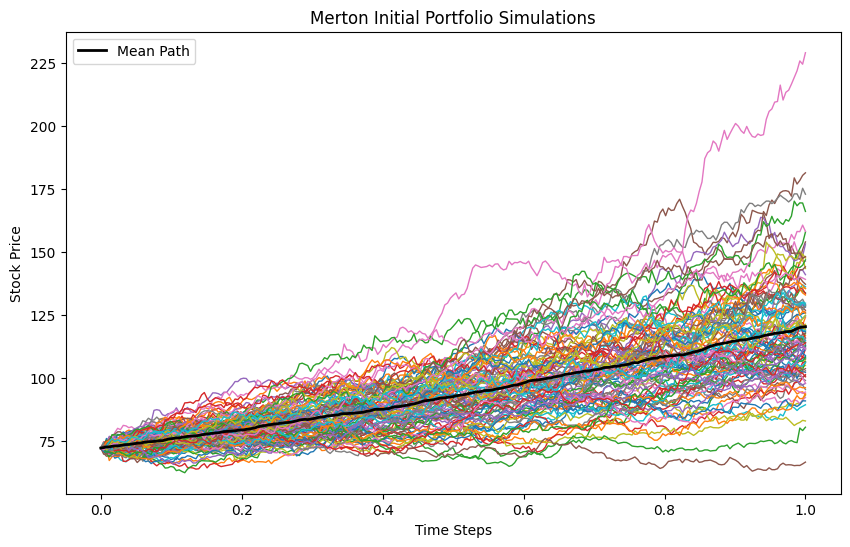

In [11]:
merton_init_port=dat_func.simulate_merton_portfolio(returns_df,stock_df,init_weights)
vis.plot_paths(merton_init_port.iloc[:100],'Merton Initial Portfolio',True)

In [12]:
merton_ret=(merton_init_port.mean(axis=0).iloc[-1]-merton_init_port.mean(axis=0).iloc[0])/merton_init_port.mean(axis=0).iloc[0]
print(f'Merton Initial Portfolio Return: {round(merton_ret*100,2)}%')

Merton Initial Portfolio Return: 65.94%


### Constant Elasticity of Variance (CEV): 

Estimated XOM CEV Parameters: mu=0.0003140325278738727, std=0.008221730134211335, gamma=1.1070639574831078


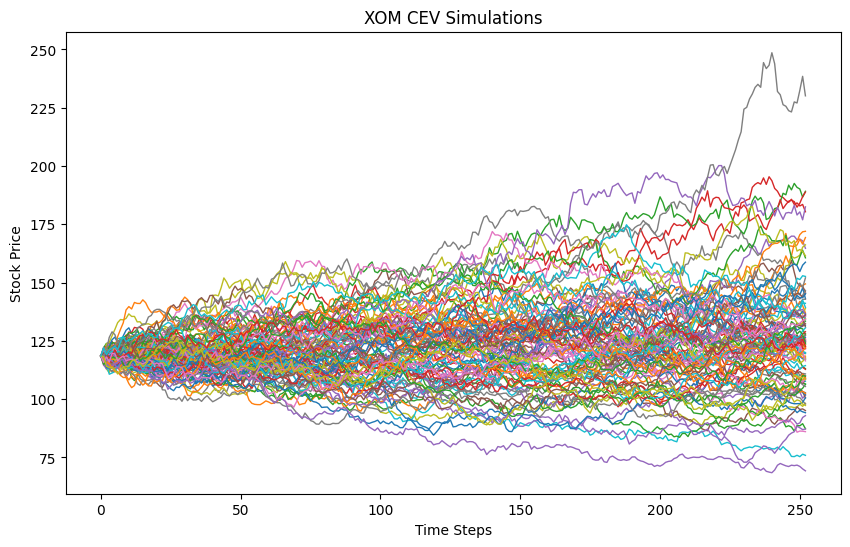

In [13]:
cev_ex_params=dat_func.estimate_cev_params(stock_series=stock_df[ex_stock])
simulated_prices = dat_func.simulate_cev(stock_df[ex_stock][-1],cev_ex_params[0]*252,cev_ex_params[1]*np.sqrt(252), gamma=cev_ex_params[2], T=1)
vis.plot_paths(simulated_prices[:100],f'{ex_stock} CEV')

Estimated ADBE CEV Parameters: mu=0.0008610097558853372, std=0.13937510555527707, gamma=0.6986745993934171
Estimated AMAT CEV Parameters: mu=0.0026791126833146718, std=0.0058031092152769324, gamma=1.2592609367404557
Estimated ATKR CEV Parameters: mu=0.0011576444163019725, std=0.06429998759115733, gamma=0.7942304171903691
Estimated FI CEV Parameters: mu=0.0008851478378471625, std=1.3013306383472245, gamma=0.00013760840503559407
Estimated GPC CEV Parameters: mu=0.0003152411402735359, std=0.0002542903543133244, gamma=1.8293641048193452
Estimated OXY CEV Parameters: mu=0.0004924209806530784, std=0.001184456499992298, gamma=1.6126936352397272
Estimated PM CEV Parameters: mu=-0.0001419953218351766, std=0.0051201287830529105, gamma=1.1473603121799325
Estimated STLD CEV Parameters: mu=0.0010212170092486718, std=2.0439446124337115, gamma=0.0
Estimated VICI CEV Parameters: mu=-0.0005683784829857893, std=0.359081447809227, gamma=0.0
Estimated WMT CEV Parameters: mu=0.0008522262059293255, std=0.00

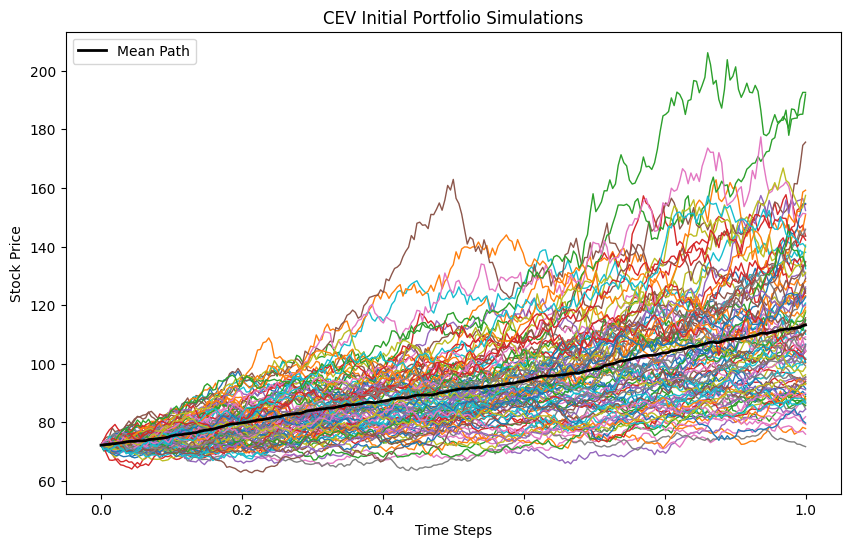

In [14]:
cev_init_port=dat_func.simulate_cev_portfolio(stock_df,init_weights)
vis.plot_paths(cev_init_port.iloc[:100],'CEV Initial Portfolio',True)

In [15]:
cev_ret=(cev_init_port.mean(axis=0).iloc[-1]-cev_init_port.mean(axis=0).iloc[0])/cev_init_port.mean(axis=0).iloc[0]
print(f'CEV Initial Portfolio Return: {round(cev_ret*100,2)}%')

CEV Initial Portfolio Return: 62.12%


### Heston Model:

In [16]:
ex_heston_param=dat_func.estimate_heston_params(ex_stock,end_date,stock_df,risk_free_rate)

Calibrated XOM parameters: theta=0.07335012320947418, kappa=3.5383325919058817, sigma=0.16605373903341053, rho=-0.9999977783947803, v0=0.011464510375516648


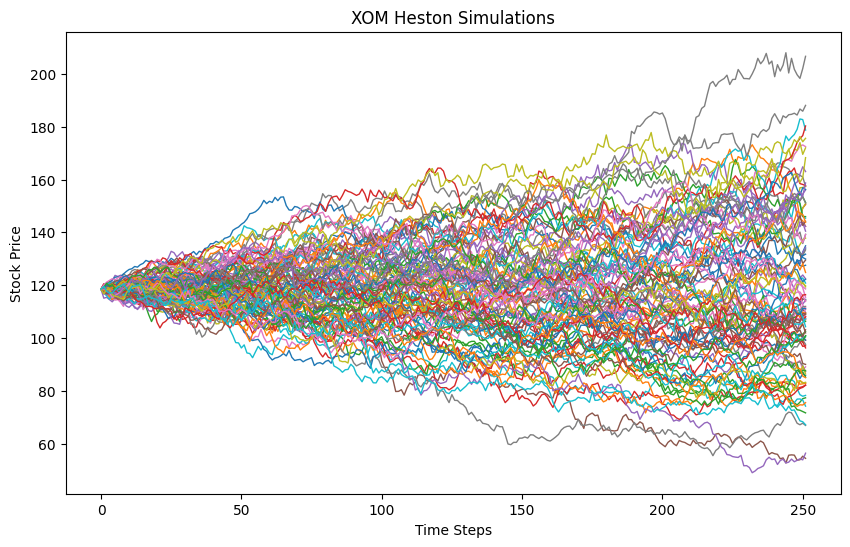

In [17]:
ex_heston_prices=dat_func.simulate_heston(ex_heston_param, stock_df[ex_stock][-1], risk_free_rate)
vis.plot_paths(ex_heston_prices[:100],f'{ex_stock} Heston')